In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as plb
import h5py
import math
import pandas as pd
import scikitplot as skplt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from astropy.stats import mad_std
from scipy import asarray as ar,exp
from scipy.signal import resample
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
#plt.style.use('seaborn-white')
plt.rcParams['xtick.labelsize']  = 18
plt.rcParams['ytick.labelsize']  = 18
plt.rcParams['axes.labelsize']   = 18
plt.rcParams['axes.titlesize']   = 18
plt.rcParams['legend.fontsize']  = 18

In [0]:
def loadh5File(filename):
    """Load h5 database and return signal and time arrays.

    >> loadh5File("input.h5")
    data, time
    """
    h5 = h5py.File(filename,'r')
    print(list(h5.keys()))
    time = np.array(h5['time'])
    data = np.array(h5['data'])
    print(np.shape(data))
    m = np.shape(data)
    m, n = m[0]*m[1], m[2]
    signal = np.zeros([m,n])
    k = 0
    for i in range(len(data)):
        for j in range(len(data[i])):
            signal[k] = data[i][j]
            k += 1
    print(np.shape(signal))
    #return data, time
    return signal, time


def removeOffset(data, a, b):
    """Remove signal offset.

    a: número de amostras utilizadas.

    >>> removeOffset(signalArray)
    signalWithoutOffset
    """
    for i in range(len(data)):
        data[i] = data[i] - np.mean(data[i][a:b])
    return data


def plotMeanSignals(signal):
    ind  = [n*100 for n in range(211)]
    m, n = np.shape(signal)
    signal_mean = np.zeros([210,n])
    for i in range(210):
        signal_mean[i] = np.mean(signal[ind[i]:ind[i+1]-1],axis=0)

    print(np.shape(signal_mean))

    fig = plt.figure(figsize=(7,5))
    plt.plot(signal_mean.T)
    #plt.grid()
    plt.xlabel('Amostras')
    plt.ylabel('Amplitude')
    plt.show()
    return


def chargeDist(signal, f, b):
    """Charge estimation.

    f: sampling frequency (ex.: 5GS/s);
    b: histogram bins

    >>> chargeEst(data, 5*10**9, 100)
    qest
    """
    fesc  = 10**12               #Fator de conversão de escala
    req   = 50                   #Resistência equivalente vista pela PMT
    dt    = 1/f                  #Frequência de aquisição
    qest  = (fesc/req)*(sum(signal.T*dt))
    yh,xh = np.histogram(qest,bins=b)
    xh    = np.delete(xh, -1)
    return qest, xh, yh


def signalAmp(signal, flag):
    """Get signal amplitudes.

    flag == 1 -> return column vector

    >>> signalAmp(data)
    ampArray
    """
    pico = np.max(signal, axis=1)
    if flag == 1:
        pico = np.reshape(pico, (-1,1))
    return pico


def linearCoef(pico, qest):
    """Amplitude x Charge linear coefficients.

    >>> linearCoef(pico, qest)
    pfit, lcov
    """ 
    pfit,lcov = np.polyfit(pico, qest, 1, cov='true')
    print("Coeficientes:\t\t", pfit)
    print("Matriz de covariância:  ", lcov[0], "\n\t\t\t", lcov[1])
    return pfit, lcov


def fwhm(signal):
    fwhm = np.zeros((signal.shape[0],1))
    for i in range(signal.shape[0]):
        dist = [d for d in range(signal.shape[1]) if signal[i][d] >= max(signal[i])/2]
        fwhm[i] = max(dist) - min(dist)
    return fwhm

# Sinais de saída da front-end

- Taxa de aquisição: 1.25GS/s
- Offset: 11000 (REG)

## Pré-processamento

In [0]:
signal_fe, time_fe = loadh5File("offvalor_11000.0_3.5M.h5")
signal_fe = signal_fe[:,100:450]
print(np.shape(signal_fe))
signal_fe = removeOffset(signal_fe, 20, 40)
signal_fe = np.roll(signal_fe, -20)

['data', 'offvalue', 'time']
(210, 100, 500)
(21000, 500)
(21000, 350)


In [0]:
#from scipy import signal
#signal_fe = signal.filtfilt(np.ones(5)/5, 1, signal_fe,padlen=299)
#signal_fe = removeOffset(signal_fe, 20, 40)

(210, 350)


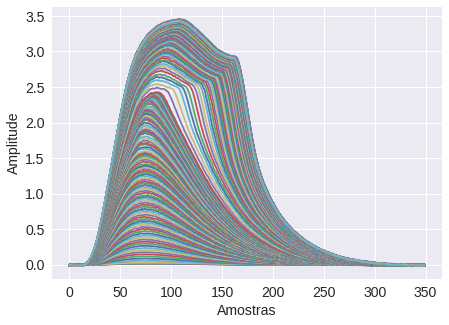

In [0]:
plotMeanSignals(signal_fe)

## Quantização dos sinais

Cada ADC equivale a 9.8 mV.

Pedestal médio observado no experimento: 36 ADC.

In [0]:
signal_fe = np.round(signal_fe/(9.8*10**-3)) - 36 

In [0]:
isat = np.where(np.max(signal_fe, axis=1) > 127)[0]
for i in isat:
  ind = np.where(signal_fe[i,:] > 127)[0]
  signal_fe[i,ind] = 127

In [0]:
# Retirando pedestal dos sinais após quantização
signal_fe = signal_fe + 36

(210, 350)


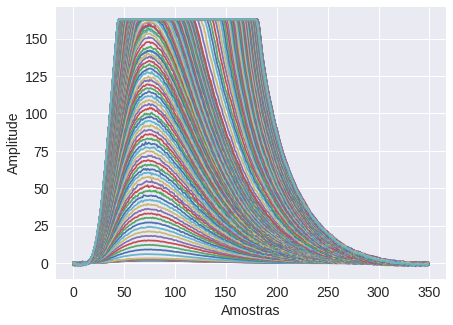

In [0]:
plotMeanSignals(signal_fe)

## Amplitude x Carga

In [0]:
fesc = 10**6
req = 50
dt = 1/(1.25*10**9)
qest_out = (fesc/req)*(sum(signal_fe.T*dt))
amp_out = np.max(signal_fe, axis=1)

In [0]:
ind = np.where(qest_out <= 0.25)
pfit_out,lcov_out = np.polyfit(qest_out[ind], amp_out[ind], 1, cov='true')
print("Coeficientes:\t\t", pfit_out)
print("Matriz de covariância:  ", lcov_out[0], "\n\t\t\t", lcov_out[1])

Coeficientes:		 [661.24021927   1.62280265]
Matriz de covariância:   [ 0.23899728 -0.02796989] 
			 [-0.02796989  0.00490264]


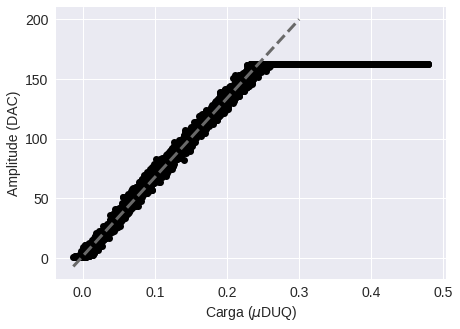

In [0]:
xfit_out = np.linspace(min(qest_out),0.3,100) 
yfit_out = pfit_out[0]*xfit_out + pfit_out[1]

fig = plt.figure(figsize=(7,5))

plt.plot(qest_out, amp_out, 'ok')
plt.plot(xfit_out, yfit_out, color='dimgray',linestyle='--',linewidth=3,label='Aquisição')
plt.xlabel('Carga ($\mu$DUQ)')
plt.ylabel('Amplitude (DAC)')

plt.show()

# Geração do Banco de Dados para classificação

In [0]:
signal_out, time_out = loadh5File("offvalor_11000.0_3.5M.h5")
signal_out = removeOffset(signal_out, 120, 140)
signal_out.shape

['data', 'offvalue', 'time']
(210, 100, 500)
(21000, 500)


(21000, 500)

In [0]:
# Quantização:  Cada ADC equivale a 9.8 mV.
#               Pedestal médio observado no experimento: 36 ADC.

signal_out = np.round(signal_out/(9.8*10**-3)) - 36
samples    = 50
signal_out = resample(signal_out, samples, axis=1)

isig = np.where(np.max(signal_out,axis=1) < 128)[0]     #Índices de sinais bons    
isat = np.where(np.max(signal_out,axis=1) >= 128)[0]    #Índices de sinais saturados

for i in isat:
    ind = np.where(signal_out[i,:] >= 127)[0]
    signal_out[i,ind] = 127

signal_out = signal_out + 36    #Retirada do pedestal
signal_out = np.roll(signal_out, -6)
signal_out.shape

(21000, 50)

In [0]:
for i in range(len(signal_out)):
    signal_out[i][42:50] = np.std(signal_out[i][38:42])*np.random.randn(8)+signal_out[i,41]

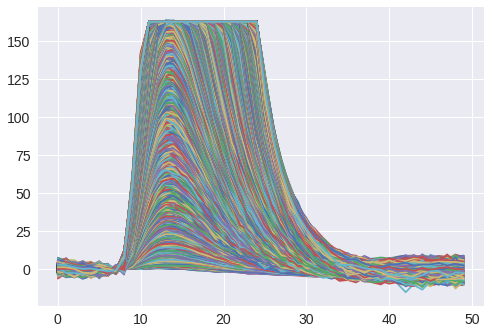

In [0]:
plt.plot(signal_out.T)
plt.show()

## Classes de sinais

In [0]:
sig = signal_out[isig,:]
sat = signal_out[isat,:]
print("Não saturados: ", sig.shape)
print("    Saturados: ", sat.shape)

Não saturados:  (7082, 50)
    Saturados:  (13918, 50)


In [0]:
# Excluindo sinais de baixa energia (Amplitude < 4 ADC)
ind = np.where(np.max(sig, axis=1) >= 4.5)[0]
sig = sig[ind,:]
sig.shape

(5991, 50)

In [0]:
# Sinais cortados no início da janela
n = 7000
wd = np.random.randint(1100,11000,n)   #Sortear n janelas a partir de 1000
ctd = np.zeros((n, signal_out.shape[1]))
j = 0
# Início da janela
for i in wd[0:int(len(wd)/2)]:
    r   = np.random.randint(8,20)    # Número de índices deslocados
    ctd[j] = np.roll(signal_out[i], -r)
    ind = 50 - r
    ctd[j][ind:50] = np.std(signal_out[i][40:50])*np.random.randn(r)  #Adicionar ruído nas últimas amostras
    j += 1

# Final da janela
for i in wd[int(len(wd)/2):int(len(wd))]:
    r   = np.random.randint(23,41)    # Número de índices deslocados
    ctd[j] = np.roll(signal_out[i], r)
    ind = r - 6
    ctd[j][0:ind] = np.std(signal_out[i][0:5])*np.random.randn(ind)  #Adicionar ruído nas últimas amostras
    j += 1

print("Cortados: ", ctd.shape)

Cortados:  (7000, 50)


In [0]:
# Dois sinais em uma janela
n = 7000
wd = np.random.randint(1100,11000,n)   #Sortear n janelas a partir de 1100
dpc = np.zeros((n, signal_out.shape[1]))
j = 0
for i in wd:
    r = np.random.randint(6,35,1)
    k  = np.random.randint(1000,11000,1)[0]   #Sortear outra janela 
    ind = np.where(signal_out[i][14:50] <= np.roll(signal_out[k],r)[14:50])[0] 
    while len(ind) == 0:
        k  = np.random.randint(1000,11000,1)[0]   #Sortear outra janela 
        ind = np.where(signal_out[i][14:50] <= np.roll(signal_out[k],r)[14:50])[0] 
    l = ind[0] + 14
    dpc[j] = signal_out[i]
    dpc[j][l:50] = np.roll(signal_out[k], r)[l:50]
    j +=1

print("Com mais de um pico: ", dpc.shape)

Com mais de um pico:  (7000, 50)


In [0]:
i = np.array(range(10))
sig = np.delete(sig,i,axis=0)
sig.shape

(5981, 50)

In [0]:
#Outliers após cálculo da FWHM
i = [ 68,  71,  80,  84,  89, 142]
sig = np.delete(sig,i,axis=0)
sig.shape

(5975, 50)

In [0]:
#Salvando os bancos de dados em um arquivo .h5
hf = h5py.File('db_sinais.h5', 'w')   
hf.create_dataset('esperados', data=sig)
hf.create_dataset('saturados', data=sat)
hf.create_dataset('cortados',  data=ctd)
hf.create_dataset('doisPicos', data=dpc)
hf.close()

## Extração de parâmetros

- Amplitude
- Área
- Posição da Amplitude
- Largura à meia altura
- Label

In [0]:
#Sinais bons (label 1)
amp_sig  = np.max(sig, axis=1).reshape(-1,1)
area_sig = sum(sig.T).reshape(-1,1)*(0.8)
pAmp_sig = np.argmax(sig,axis=1).reshape(-1,1)
dist_sig = fwhm(sig)
lb_sig   = 1*np.ones((sig.shape[0],1))
db_sig   = np.concatenate((amp_sig, area_sig, pAmp_sig, dist_sig, lb_sig), axis=1)
db_sig.shape

(5975, 5)

In [0]:
#Sinais saturados (label 2)
amp_sat  = np.max(sat, axis=1).reshape(-1,1)
area_sat = sum(sat.T).reshape(-1,1)*(0.8)
pAmp_sat = np.argmax(sat,axis=1).reshape(-1,1)
dist_sat = fwhm(sat)
lb_sat   = 2*np.ones((sat.shape[0],1))
db_sat   = np.concatenate((amp_sat, area_sat, pAmp_sat, dist_sat,lb_sat), axis=1)
db_sat.shape

(13918, 5)

In [0]:
#Sinais cortados (label 3)
amp_ctd  = np.max(ctd, axis=1).reshape(-1,1)
area_ctd = sum(ctd.T).reshape(-1,1)*(0.8)
pAmp_ctd = np.argmax(ctd,axis=1).reshape(-1,1)
dist_ctd = fwhm(ctd)
lb_ctd   = 3*np.ones((ctd.shape[0],1))
db_ctd   = np.concatenate((amp_ctd, area_ctd, pAmp_ctd, dist_ctd, lb_ctd), axis=1)
db_ctd.shape

(7000, 5)

In [0]:
#Sinais com dois picos (label 4)
amp_dpc  = np.max(dpc, axis=1).reshape(-1,1)
area_dpc = sum(dpc.T).reshape(-1,1)*(0.8)
pAmp_dpc = np.argmax(dpc,axis=1).reshape(-1,1)
dist_dpc = fwhm(dpc)
lb_dpc   = 4*np.ones((dpc.shape[0],1))
db_dpc   = np.concatenate((amp_dpc, area_dpc, pAmp_dpc, dist_dpc, lb_dpc), axis=1)
db_dpc.shape

(7000, 5)

In [0]:
#Salvando os bancos de dados de parâmetros em um arquivo .h5
hf = h5py.File('db_sinais_par.h5', 'w')   
hf.create_dataset('esperados', data=db_sig)
hf.create_dataset('saturados', data=db_sat)
hf.create_dataset('cortados',  data=db_ctd)
hf.create_dataset('doisPicos', data=db_dpc)
hf.close()

## Dataframe

In [0]:
df = pd.DataFrame(np.concatenate((db_sig, db_sat, db_ctd, db_dpc), axis=0), 
                  columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
df.to_csv('DataFrame_Aqst.csv')
df.head()

,Amp,Area,Pos_Amp,FWHM,Label
0,6.023878,56.830998,14.0,8.0,1.0
1,5.075051,-37.835989,13.0,6.0,1.0
2,5.075051,-37.945485,13.0,6.0,1.0
3,5.573990,29.943948,14.0,7.0,1.0
4,5.061862,-21.486767,14.0,8.0,1.0


# Load do banco de dados criado

In [5]:
h5 = h5py.File('db_sinais.h5','r')
print(list(h5.keys()))
sig = np.array(h5['esperados'])
sat = np.array(h5['saturados'])
ctd = np.array(h5['cortados'])
dpc = np.array(h5['doisPicos'])

['cortados', 'doisPicos', 'esperados', 'saturados']


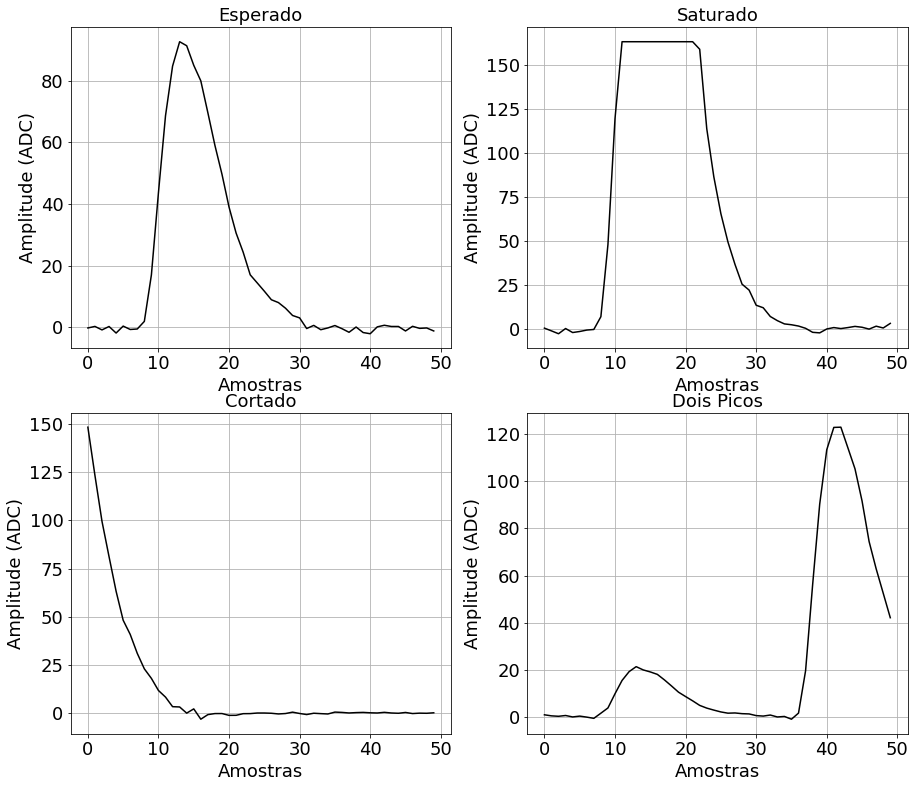

In [8]:
fig = plt.figure(figsize=(15,13))

fig.add_subplot(2,2,1)
plt.plot(sig[3015],'k')
plt.xlabel('Amostras')
plt.ylabel('Amplitude (ADC)')
plt.title('Esperado')
plt.grid()

fig.add_subplot(2,2,2)
plt.plot(sat[6000],'k')
plt.xlabel('Amostras')
plt.ylabel('Amplitude (ADC)')
plt.title('Saturado')
plt.grid()

fig.add_subplot(2,2,3)
plt.plot(ctd[2500],'k')
plt.xlabel('Amostras')
plt.ylabel('Amplitude (ADC)')
plt.title('Cortado')
plt.grid()

fig.add_subplot(2,2,4)
plt.plot(dpc[2500],'k')
plt.xlabel('Amostras')
plt.ylabel('Amplitude (ADC)')
plt.title('Dois Picos')
plt.grid()

plt.show()

# Comparação dos sinais do experimento com os simulados

In [0]:
sinais_bons = np.load('/content/drive/My Drive/Mestrado/Estimação_Neutrinos/Sinais_Mari/Sinais_bons.npy','r')
sinais_bons.shape

(2012, 50)

In [0]:
print(np.argmax(sinais_bons[1000]))
print(np.argmax(sig[5500]))

15
13


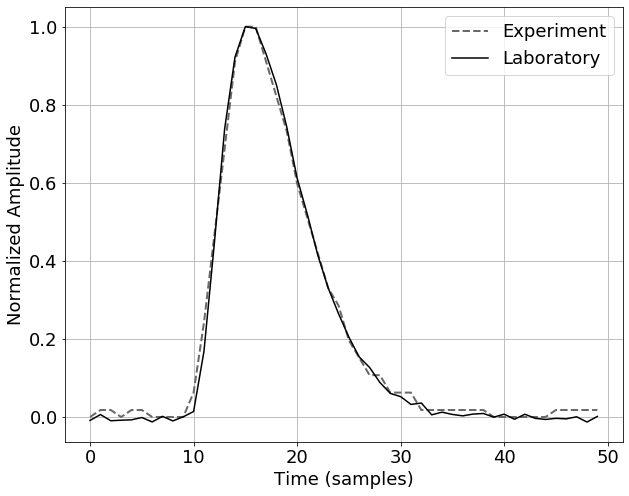

In [0]:
plt.figure(figsize=(10,8))
plt.plot(sinais_bons[1000]/max(sinais_bons[1000]),'--', color='dimgray',linewidth=2.0,label='Experiment')
plt.plot(np.roll(sig[5500]/max(sig[5500]),2),'k',label='Laboratory')
plt.xlabel('Time (samples)')
plt.ylabel('Normalized Amplitude')
plt.grid()
plt.legend()

#fig.tight_layout()
plt.savefig('signal_shape.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Análise dos parâmetros

In [0]:
#Load DataFrame
df = pd.read_csv('DataFrame_Aqst.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,Amp,Area,Pos_Amp,FWHM,Label
0,6.023878,56.830998,14.0,8.0,1.0
1,5.075051,-37.835989,13.0,6.0,1.0
2,5.075051,-37.945485,13.0,6.0,1.0
3,5.573990,29.943948,14.0,7.0,1.0
4,5.061862,-21.486767,14.0,8.0,1.0


In [0]:
df['Amp/Area'] = df['Amp']/df['Area']
df.head()

,Amp,Area,Pos_Amp,FWHM,Label,Amp/Area
0,6.023878,71.298868,14.0,8.0,1.0,0.084488
1,5.075051,-47.280136,13.0,6.0,1.0,-0.107340
2,5.075051,-48.673001,13.0,6.0,1.0,-0.104268
3,5.573990,37.297597,14.0,7.0,1.0,0.149446
4,5.061862,-25.961596,14.0,8.0,1.0,-0.194975


## Amplitude das classes

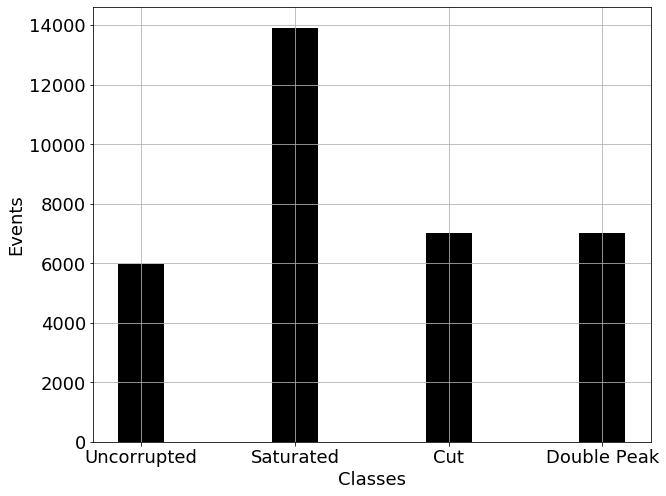

In [0]:
amp = np.array([])
for i in range(1,5):
    amp = np.append(amp, len(df.loc[(df['Label'] == i)]))

classes = ['Uncorrupted', 'Saturated', 'Cut', 'Double Peak']
plt.figure(figsize=(10,8))
plt.bar(classes, amp, width=0.3, color='black')
plt.xlabel('Classes')
plt.ylabel('Events')
plt.grid()

#fig.tight_layout()
plt.savefig('amp_classes.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## PDF dos parâmetros

In [0]:
classes = ['Uncorrupted', 'Saturated', 'Cut', 'Double Peak']

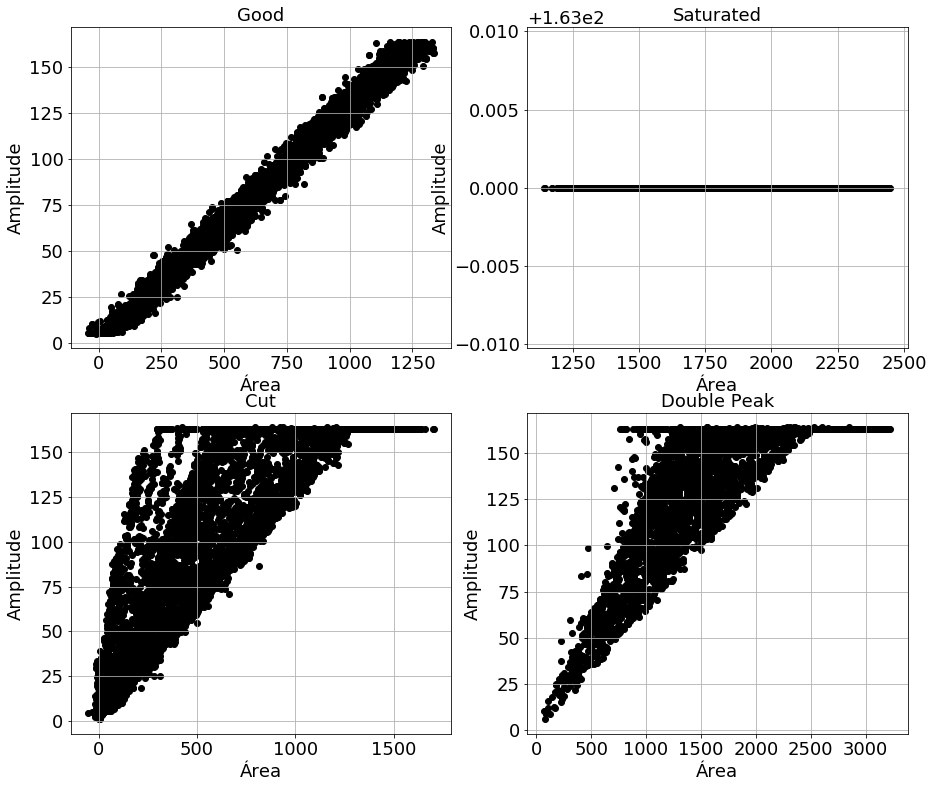

In [0]:
#Amplitude x Área (Plots individuais)
fig = plt.figure(figsize=(15,13))

for i in range(4):
    amp  = df["Amp"][df["Label"] == i+1]
    area = df["Area"][df["Label"] == i+1]
    fig.add_subplot(2,2,i+1)
    plt.scatter(area,amp, label=classes[i],color='black')
    plt.title(classes[i])
    plt.xlabel('Área')
    plt.ylabel('Amplitude')
    plt.grid()

plt.show()

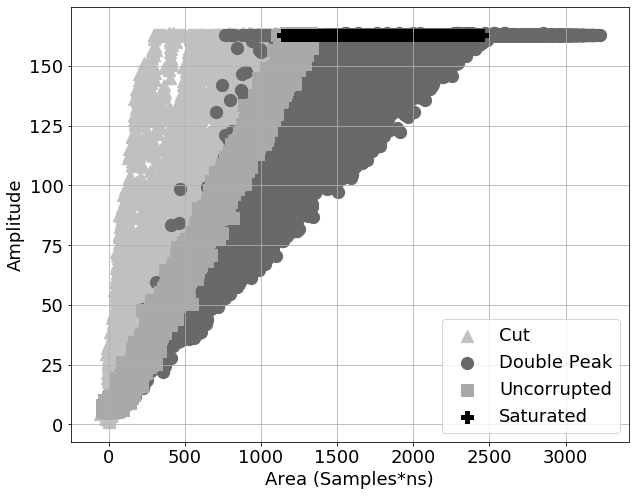

In [0]:
#Amplitude x Área
plt.figure(figsize=(10,8))
cl = [2,3,0,1]
color = ['darkgrey','black', 'silver', 'dimgray']
mk = ('s','P','^','o')
for i in cl:
    amp  = df["Amp"][df["Label"] == i+1]
    area = df["Area"][df["Label"] == i+1]
    plt.scatter(area,amp,label=classes[i],marker=mk[i],s=150,color=color[i])#,edgecolors=color[i],facecolor='None')

plt.legend()
plt.xlabel('Area (Samples*ns)')
plt.ylabel('Amplitude')
plt.grid()
#plt.savefig('area_amp_sim3.png', format='png',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

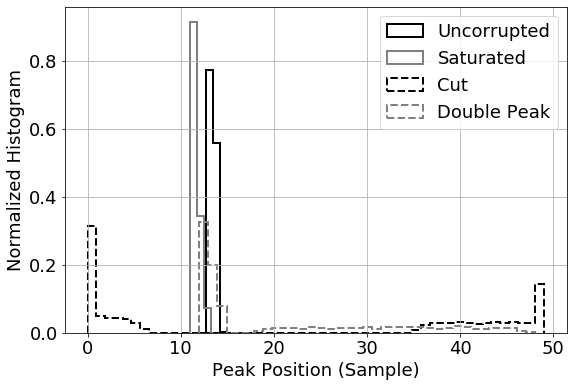

In [0]:
#Posição do pico
bins = [4, 4, 52, 37]
color = ['black','gray','black','gray']
linestyle = ['-','-','--','--']

plt.figure(figsize=(9,6))
for i in range(4):
    plt.hist(df["Pos_Amp"][df["Label"]==i+1],label = classes[i], bins = bins[i], density=True,
           histtype= 'step',linewidth = 2.0, linestyle=linestyle[i], color=color[i])

plt.legend()
plt.xlabel('Peak Position (Sample)')
plt.ylabel('Normalized Histogram')
#plt.yscale('log')
plt.grid()

#fig.tight_layout()
plt.savefig('pos_amp.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

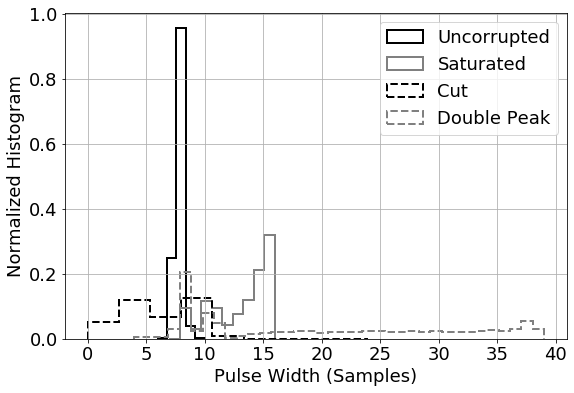

In [0]:
#Largura à meia altura
bins = [5, 10, 9, 36]
color = ['black','gray','black','gray']
linestyle = ['-','-','--','--']

plt.figure(figsize=(9,6))
for i in range(4):
    plt.hist(df["FWHM"][df["Label"]==i+1],label = classes[i], bins = bins[i], density=True, 
           histtype= 'step',linewidth = 2.0, linestyle=linestyle[i], color=color[i])

plt.legend()
plt.xlabel('Pulse Width (Samples)')
plt.ylabel('Normalized Histogram')
#plt.yscale('log')
plt.grid()

#fig.tight_layout()
plt.savefig('pulse_width.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Modelagem de hiperparâmetros

In [0]:
Y = np.array(df['Label'])  
X = df.drop(['Label'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

## MLP

In [0]:
neurons = range(1,21,1)
MLP_1  = np.array([])
for i in neurons:
    MLP = MLPClassifier(hidden_layer_sizes=(i), solver='sgd', max_iter=2000, random_state=1, activation='relu')
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    results_MLP  = cross_validate(MLP, X=X, y=Y, cv=kfold, scoring='f1_micro')
    MLP_1 = np.concatenate((MLP_1, results_MLP['test_score']),axis=0)

np.save('MLP_1', MLP_1.reshape(20,10))

In [0]:
MLP_2 = np.array([])
neurons = range(1,21)
for i in neurons:
    MLP = MLPClassifier(hidden_layer_sizes=(i,i), solver='sgd', max_iter=2000, random_state=1, activation='relu')
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    results_MLP = cross_validate(MLP, X=X, y=Y, cv=kfold, scoring='f1_micro')
    MLP_2 = np.concatenate((MLP_2, results_MLP['test_score']),axis=0)

np.save('MLP_2', MLP_2.reshape(20,10))

In [0]:
MLP_3 = np.array([])
neurons = range(1,21)
for i in neurons:
    MLP = MLPClassifier(hidden_layer_sizes=(i,i,i), solver='sgd', max_iter=2000, random_state=1, activation='relu')
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    results_MLP = cross_validate(MLP, X=X, y=Y, cv=kfold, scoring='f1_micro')
    MLP_3 = np.concatenate((MLP_3, results_MLP['test_score']),axis=0)

np.save('MLP_3', MLP_3.reshape(20,10))

In [0]:
MLP_1 = np.load('./MLP/MLP_1.npy')
MLP_2 = np.load('./MLP/MLP_2.npy')
MLP_3 = np.load('./MLP/MLP_3.npy')

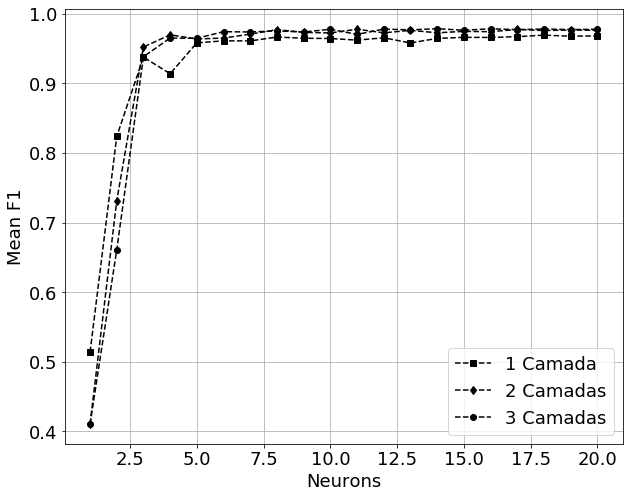

In [0]:
fig = plt.figure(figsize=(10,8))

plt.plot(list(range(1,21)), np.mean(MLP_1,axis=1), '--ks',label='1 Camada')
plt.plot(list(range(1,21)), np.mean(MLP_2,axis=1), '--kd',label='2 Camadas')
plt.plot(list(range(1,21)), np.mean(MLP_3,axis=1), '--ko',label='3 Camadas')

plt.xlabel('Neurons')
plt.ylabel('Mean F1')
plt.legend()
plt.grid()

#plt.savefig('mlp_mean.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

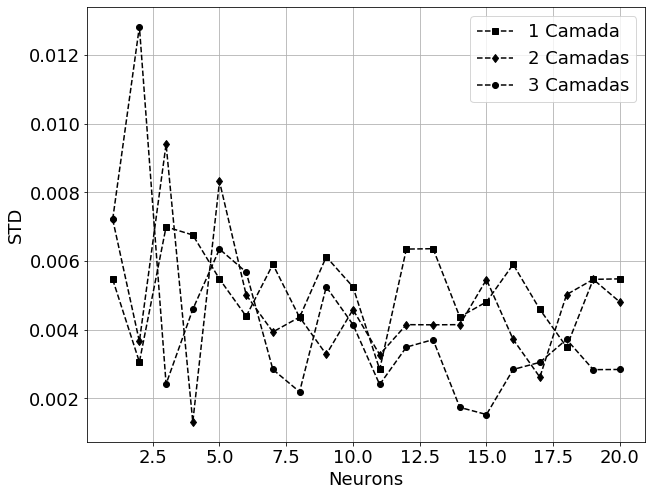

In [0]:
fig = plt.figure(figsize=(10,8))

plt.plot(list(range(1,21)), mad_std(MLP_1,axis=1), '--ks',label='1 Camada')
plt.plot(list(range(1,21)), mad_std(MLP_2,axis=1), '--kd',label='2 Camadas')
plt.plot(list(range(1,21)), mad_std(MLP_3,axis=1), '--ko',label='3 Camadas')

plt.xlabel('Neurons')
plt.ylabel('STD')
plt.grid()
plt.legend()
#plt.savefig('mlp_std.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Regressão Logística

In [0]:
clf_LR = LogisticRegression(random_state=1, max_iter=500, solver='sag')
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_LR = cross_validate(clf_LR, X=X, y=Y, cv=kfold, scoring='accuracy')

print('Acurácia:',results_LR['test_score'].mean())
print('STD:\t ',results_LR['test_score'].std())

Acurácia: 0.8470482586817842
STD:	  0.006325134936614035


## Floresta Aleatória

In [0]:
f1_RF = np.array([])
std_RF = np.array([])
trees = range(1,201,5)
for i in trees:
    RF = RandomForestClassifier(n_estimators=i, bootstrap=True, random_state=1)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    results_RF = cross_validate(RF, X=X, y=Y, cv=kfold, scoring='f1_micro')
    f1_RF      = np.append(f1_RF,  (results_RF['test_score'].mean()))
    std_RF     = np.append(std_RF, mad_std(results_RF['test_score']))

In [0]:
np.save('f1_RF', f1_RF)
np.save('std_RF', std_RF)

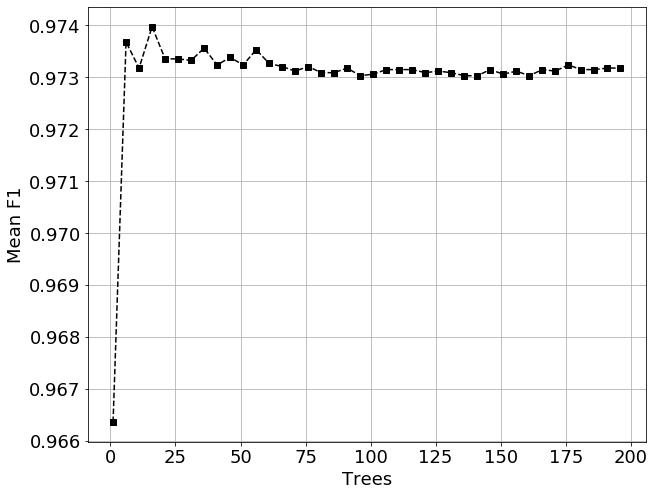

In [0]:
fig = plt.figure(figsize=(10,8))

plt.plot(list(range(1,201,5)), f1_RF, '--ks')

plt.xlabel('Trees')
plt.ylabel('Mean F1')
plt.grid()

plt.savefig('rf_mean.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

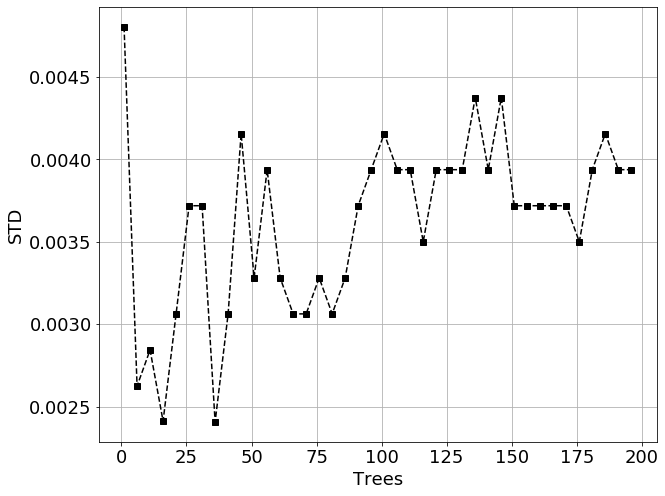

In [0]:
fig = plt.figure(figsize=(10,8))

plt.plot(list(range(1,201,5)), std_RF, '--ks')

plt.xlabel('Trees')
plt.ylabel('STD')
plt.grid()

plt.savefig('rf_std.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Algoritmo Neutrinos

In [0]:
def rotate(oX, oY, pX, pY, angle):
    from math import sin
    from math import cos
    from numpy import array
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    """
    ox = oX
    oy = oY
    px = array(pX)
    py = array(pY)

    qx = ox + cos(angle) * (px - ox) - sin(angle) * (py - oy)
    qy = oy + sin(angle) * (px - ox) + cos(angle) * (py - oy)
    
    return qx.tolist(), qy.tolist()

def getAngle(X,Y):
    from numpy import polyfit
    from numpy import poly1d
    from numpy import arctan
    
    # - - - - Reta 0,0
    xo = [-2048,2048]
    yo = [0.001,0.001]
    
    zo = polyfit(yo,xo, 1)
    fo = poly1d(zo)    
    m1 = fo.c[0] 
    
    z = polyfit(X,Y, 1)
    func = poly1d(z) 
    m2 = func.c[0]
    
    
    
    angle = arctan(m1-m2/(1-m1*m2))
    
    return angle

In [0]:
def dfSplit(X, Y, trainSize):
    dfTrain = pd.DataFrame(np.concatenate((xTrain, yTrain.reshape(-1,1)), axis=1), 
                  columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
    dfTest = pd.DataFrame(np.concatenate((xTest, yTest.reshape(-1,1)), axis=1), 
                  columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
    return dfTrain, dfTest

In [0]:
def hardCuts(newX_sig, i, df):
    cutLow = np.mean(newX_sig) - i*mad_std(newX_sig)
    cutUpp = np.mean(newX_sig) + i*mad_std(newX_sig)
      
    df.Tag[df.index[(df.AreaRot >= cutLow) & (df.AreaRot <= cutUpp)]] = 1    
    df.Tag[df.index[(df.AreaRot < cutLow)]] = 3
    df.Tag[df.index[(df.AreaRot > cutUpp)]] = 4
    df.Tag[df.index[(df.Amp >= 163)]] = 2
    df.Tag[df.index[(df.Pos_Amp <= 8) | (df.Pos_Amp >= 46)]]  = 3
    df.Tag[df.index[(df.Pos_Amp >= 15) & (df.Pos_Amp <= 35)]] = 4
    df.Tag[df.index[(df.FWHM >= 17)]] = 4
    df.Tag[df.index[(df.FWHM <= 6)]]  = 3
    return df

In [0]:
def NeutrinosClassifier(df, angle, sigma):   
    if angle == 'None':
        angle = getAngle(df.Area[df.Label==1],df.Amp[df.Label==1]) 
    
    newX_sig,newY_sig = rotate(0,0,df.Area[df.Label==1],df.Amp[df.Label==1],angle+math.radians(90))
    newX_dpc,newY_dpc = rotate(0,0,df.Area[df.Label==4],df.Amp[df.Label==4],angle+math.radians(90))
    newX_cut,newY_cut = rotate(0,0,df.Area[df.Label==3],df.Amp[df.Label==3],angle+math.radians(90))
    newX_sat,newY_sat = rotate(0,0,df.Area[df.Label==2],df.Amp[df.Label==2],angle+math.radians(90))
    
    xRot = np.concatenate((newX_sig,newX_sat,newX_cut,newX_dpc),axis=0)
    yRot = np.concatenate((newY_sig,newY_sat,newY_cut,newY_dpc),axis=0)
    
    df['AreaRot'] = xRot
    df['Tag'] = np.zeros(len(df))
    
    nF1 = np.array([])
    
    df = hardCuts(newX_sig, sigma, df)
    f1 = f1_score(df.Label, df.Tag,average='micro')
    nF1 = np.append(nF1, f1)
    return nF1, angle, df

In [0]:
Y = np.array(df['Label'])  
X = np.array(df.drop(['Label'], axis=1))
sigma = np.linspace(0.01, 50, 100)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
NCLF = np.array([])
for i in sigma:
    results_NCLF = ([])
    for train_index, test_index in kfold.split(X):
        xTrain, xTest = X[train_index], X[test_index]
        yTrain, yTest = Y[train_index], Y[test_index]
        dfTrain = pd.DataFrame(np.concatenate((xTrain, yTrain.reshape(-1,1)), axis=1), 
                    columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
        dfTest = pd.DataFrame(np.concatenate((xTest, yTest.reshape(-1,1)), axis=1), 
                    columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
        f1_NC_train, angle = NeutrinosClassifier(dfTrain, 'None', i)
        f1_NC_test, angle  = NeutrinosClassifier(dfTest, angle, i)
        results_NCLF = np.append(results_NCLF, f1_NC_test)
    NCLF = np.concatenate((NCLF, results_NCLF),axis=0)

np.save('NCLF', NCLF.reshape(100,10))

In [0]:
sigma = np.linspace(0.01, 50, 100)
NCLF = np.load('./NCLF.npy')

In [0]:
np.argmax(np.mean(NCLF,axis=1))

5

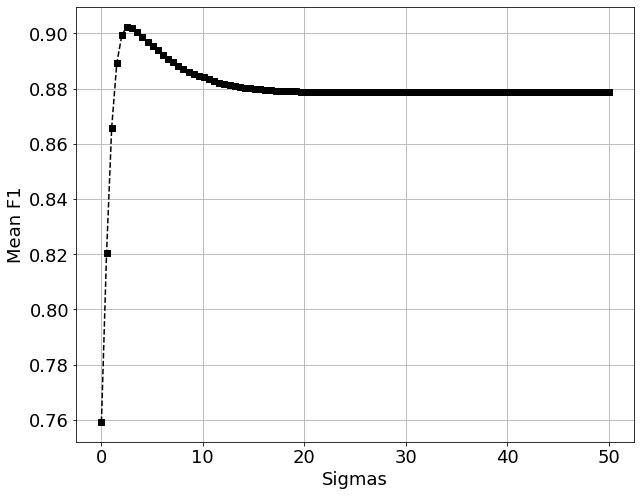

In [0]:
fig = plt.figure(figsize=(10,8))

plt.plot(sigma, np.mean(NCLF,axis=1), '--ks')
plt.xlabel('Sigmas')
plt.ylabel('Mean F1')
plt.grid()

#plt.savefig('nClf_mean.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

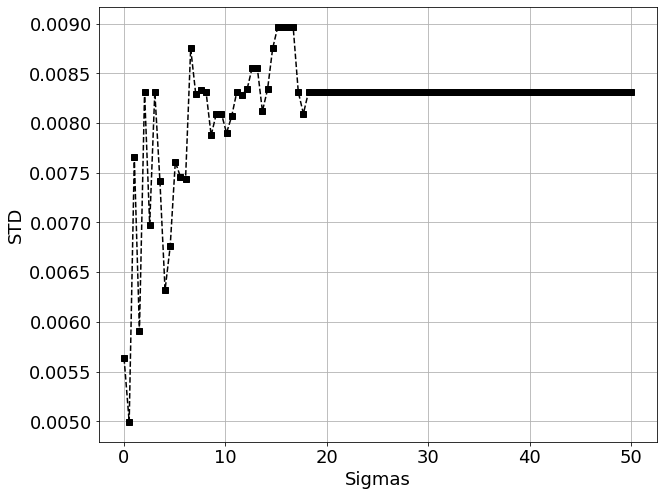

In [0]:
fig = plt.figure(figsize=(10,8))

plt.plot(sigma, mad_std(NCLF,axis=1), '--ks')
plt.xlabel('Sigmas')
plt.ylabel('STD')
plt.grid()

#plt.savefig('nClf_std.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Resultados

In [0]:
Y = np.array(df['Label'])  
X = np.array(df.drop(['Label'], axis=1))
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [0]:
# Neutrinos Algorithm
results_NCLF = ([])
f1_cm_NCLF = ([])
fa_NCLF = ([])
for train_index, test_index in kfold.split(X):
    xTrain, xTest = X[train_index], X[test_index]
    yTrain, yTest = Y[train_index], Y[test_index]
    dfTrain = pd.DataFrame(np.concatenate((xTrain, yTrain.reshape(-1,1)), axis=1), 
                columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
    dfTest = pd.DataFrame(np.concatenate((xTest, yTest.reshape(-1,1)), axis=1), 
                columns=['Amp', 'Area', 'Pos_Amp', 'FWHM', 'Label'])
    f1_NC_train, angle, dfNew = NeutrinosClassifier(dfTrain, 'None', 2.55)
    f1_NC_test, angle, dfNew  = NeutrinosClassifier(dfTest, angle, 2.55)
    cm_NCLF = confusion_matrix(dfNew.Label, dfNew.Tag,normalize='true')
    f1_cm_NCLF = np.append(f1_cm_NCLF, cm_NCLF.diagonal(), axis=0)
    fa_NCLF = np.append(fa_NCLF, np.sum(cm_NCLF,axis=0)-cm_NCLF.diagonal())
    results_NCLF = np.append(results_NCLF, f1_NC_test)

f1_cm_NCLF = f1_cm_NCLF.reshape(10,4)
fa_NCLF = fa_NCLF.reshape(10,4)

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [0]:
# MLP
results_MLP = np.array([])
f1_cm_MLP = ([])
fa_MLP = ([])
for train_index, test_index in kfold.split(X):
    xTrain, xTest = X[train_index], X[test_index]
    yTrain, yTest = Y[train_index], Y[test_index]
    clf_MLP = MLPClassifier(hidden_layer_sizes=(8,8), solver='sgd', max_iter=2000, random_state=1, activation='relu')
    clf_MLP.fit(xTrain, yTrain)
    pred_MLP = clf_MLP.predict(xTest)
    f1 = f1_score(yTest, pred_MLP,average='micro')
    cm_MLP = confusion_matrix(yTest, pred_MLP,normalize='true')
    f1_cm_MLP = np.append(f1_cm_MLP, cm_MLP.diagonal(), axis=0)
    fa_MLP = np.append(fa_MLP, np.sum(cm_MLP,axis=0)-cm_MLP.diagonal())
    results_MLP = np.append(results_MLP, f1)

f1_cm_MLP = f1_cm_MLP.reshape(10,4)

In [0]:
# Logistic Regression
results_LR = np.array([])
f1_cm_LR = np.array([])
fa_LR = ([])
for train_index, test_index in kfold.split(X):
    xTrain, xTest = X[train_index], X[test_index]
    yTrain, yTest = Y[train_index], Y[test_index]
    clf_LR = LogisticRegression(random_state=1, max_iter=2000, solver='sag')
    clf_LR.fit(xTrain, yTrain)
    pred_LR = clf_LR.predict(xTest)
    f1 = f1_score(yTest, pred_LR,average='micro')
    cm_LR = confusion_matrix(yTest, pred_LR,normalize='true')
    f1_cm_LR = np.append(f1_cm_LR, cm_LR.diagonal(), axis=0)
    fa_LR = np.append(fa_LR, np.sum(cm_LR,axis=0)-cm_LR.diagonal())
    results_LR = np.append(results_LR, f1)

f1_cm_LR = f1_cm_LR.reshape(10,4)

In [0]:
fa_MLP = fa_MLP.reshape(10,4)
fa_LR = fa_LR.reshape(10,4)

In [0]:
# Random Forest
results_RF = np.array([])
f1_cm_RF = np.array([])
fa_RF = ([])
for train_index, test_index in kfold.split(X):
    xTrain, xTest = X[train_index], X[test_index]
    yTrain, yTest = Y[train_index], Y[test_index]
    clf_RF = RandomForestClassifier(n_estimators=75, bootstrap=True, random_state=1)
    clf_RF.fit(xTrain, yTrain)
    pred_RF = clf_RF.predict(xTest)
    f1 = f1_score(yTest, pred_RF,average='micro')
    cm_RF = confusion_matrix(yTest, pred_RF,normalize='true')
    f1_cm_RF = np.append(f1_cm_RF, cm_RF.diagonal(), axis=0)
    fa_RF = np.append(fa_RF, np.sum(cm_RF,axis=0)-cm_RF.diagonal())
    results_RF = np.append(results_RF, f1)

f1_cm_RF = f1_cm_RF.reshape(10,4)
fa_RF = fa_RF.reshape(10,4)

In [0]:
np.save('results_NCLF',results_NCLF)

In [0]:
results_NCLF = np.load('results_NCLF.npy')
results_LR   = np.load('results_LR.npy')
results_MLP  = np.load('results_MLP.npy')
results_RF   = np.load('results_RF.npy')

In [0]:
clf_lb = ['Neutrinos','Logistic Regression', 'MLP', 'Random Forest']
clf_mean = np.array([results_NCLF.mean(), results_LR.mean(), results_MLP.mean(), results_RF.mean()])
clf_std = np.array([mad_std(results_NCLF), mad_std(results_LR), mad_std(results_MLP), mad_std(results_RF)])

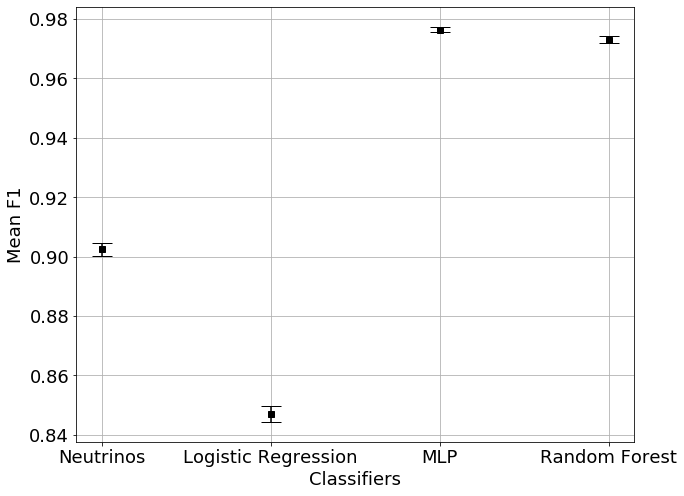

In [0]:
plt.figure(figsize=(10,8))
plt.errorbar(clf_lb, clf_mean, yerr=clf_std/np.sqrt(10),capsize=10,fmt='sk')
plt.grid()
plt.xlabel('Classifiers')
plt.ylabel('Mean F1')

#plt.savefig('F1_results.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [0]:
np.save('f1_cm_NCLF',f1_cm_NCLF)

In [0]:
np.save('f1_cm_NCLF',f1_cm_NCLF)
np.save('f1_cm_LR',f1_cm_LR)
np.save('f1_cm_MLP',f1_cm_MLP)
np.save('f1_cm_RF',f1_cm_RF)

In [0]:
f1_cm_NCLF = np.load('f1_cm_NCLF.npy')
f1_cm_LR   = np.load('f1_cm_LR.npy')
f1_cm_MLP  = np.load('f1_cm_MLP.npy')
f1_cm_RF   = np.load('f1_cm_RF.npy')

In [0]:
print(np.mean(f1_cm_NCLF,axis=0))
print(np.mean(f1_cm_LR,axis=0))
print(np.mean(f1_cm_MLP,axis=0))
print(np.mean(f1_cm_RF,axis=0))

[0.97116708 1.         0.78292697 0.7695316 ]
[0.90097714 0.98863201 0.69925003 0.66730993]
[0.97971414 0.99806734 0.99755158 0.9097769 ]
[0.98895352 0.98142234 0.99728202 0.91899857]


In [0]:
tp_sig_mean = [np.mean(f1_cm_NCLF,axis=0)[0], np.mean(f1_cm_LR,axis=0)[0], np.mean(f1_cm_MLP,axis=0)[0], np.mean(f1_cm_RF,axis=0)[0]]
tp_sat_mean = [np.mean(f1_cm_NCLF,axis=0)[1], np.mean(f1_cm_LR,axis=0)[1], np.mean(f1_cm_MLP,axis=0)[1], np.mean(f1_cm_RF,axis=0)[1]]
tp_cut_mean = [np.mean(f1_cm_NCLF,axis=0)[2], np.mean(f1_cm_LR,axis=0)[2], np.mean(f1_cm_MLP,axis=0)[2], np.mean(f1_cm_RF,axis=0)[2]]
tp_dpc_mean = [np.mean(f1_cm_NCLF,axis=0)[3], np.mean(f1_cm_LR,axis=0)[3], np.mean(f1_cm_MLP,axis=0)[3], np.mean(f1_cm_RF,axis=0)[3]]

In [0]:
tp_sig_erro = [mad_std(f1_cm_NCLF,axis=0)[0]/np.sqrt(10), mad_std(f1_cm_LR,axis=0)[0]/np.sqrt(10), mad_std(f1_cm_MLP,axis=0)[0]/np.sqrt(10), mad_std(f1_cm_RF,axis=0)[0]/np.sqrt(10)]
tp_sat_erro = [mad_std(f1_cm_NCLF,axis=0)[1]/np.sqrt(10), mad_std(f1_cm_LR,axis=0)[1]/np.sqrt(10), mad_std(f1_cm_MLP,axis=0)[1]/np.sqrt(10), mad_std(f1_cm_RF,axis=0)[1]/np.sqrt(10)]
tp_cut_erro = [mad_std(f1_cm_NCLF,axis=0)[2]/np.sqrt(10), mad_std(f1_cm_LR,axis=0)[2]/np.sqrt(10), mad_std(f1_cm_MLP,axis=0)[2]/np.sqrt(10), mad_std(f1_cm_RF,axis=0)[2]/np.sqrt(10)]
tp_dpc_erro = [mad_std(f1_cm_NCLF,axis=0)[3]/np.sqrt(10), mad_std(f1_cm_LR,axis=0)[3]/np.sqrt(10), mad_std(f1_cm_MLP,axis=0)[3]/np.sqrt(10), mad_std(f1_cm_RF,axis=0)[3]/np.sqrt(10)]

In [0]:
clf_lb = ['Neutrinos','Logistic Regression', 'MLP', 'Random Forest']

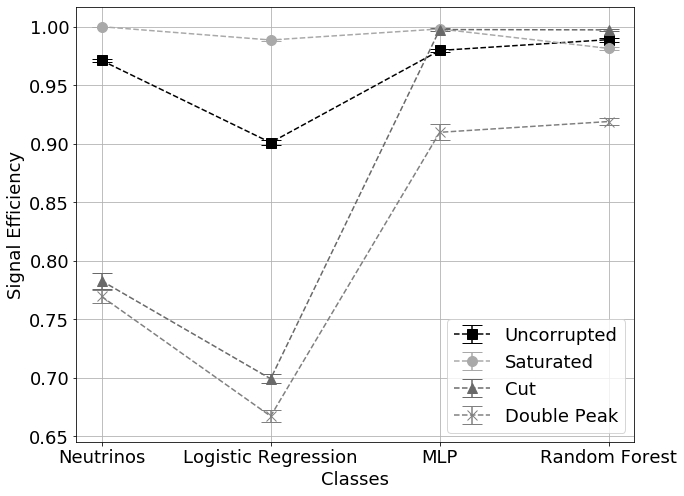

In [0]:
classes = np.array(['Uncorrupted', 'Saturated', 'Cut', 'Double Peak'])

plt.figure(figsize=(10,8))
plt.errorbar(clf_lb, tp_sig_mean, yerr=tp_sig_erro,capsize=10,fmt='--s',label='Uncorrupted',markersize=10,color='black')
plt.errorbar(clf_lb, tp_sat_mean, yerr=tp_sat_erro,capsize=10,fmt='--o',label='Saturated',markersize=10,color='darkgrey')
plt.errorbar(clf_lb, tp_cut_mean, yerr=tp_cut_erro,capsize=10,fmt='--^',label='Cut',markersize=10,color='dimgray')
plt.errorbar(clf_lb, tp_dpc_mean, yerr=tp_dpc_erro,capsize=10,fmt='--x',label='Double Peak',markersize=10,color='gray')


plt.grid()
plt.legend()
plt.xlabel('Classes')
plt.ylabel('Signal Efficiency')

plt.savefig('efficiency.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [0]:
np.save('fa_NCLF',fa_NCLF)

In [0]:
np.save('fa_NCLF',fa_NCLF)
np.save('fa_LR',fa_LR)
np.save('fa_MLP',fa_MLP)
np.save('fa_RF',fa_RF)

In [0]:
fa_NCLF = np.load('fa_NCLF.npy')
fa_LR   = np.load('fa_LR.npy')
fa_MLP  = np.load('fa_MLP.npy')
fa_RF   = np.load('fa_RF.npy')

In [0]:
fa_sig_mean = [np.mean(fa_NCLF,axis=0)[0], np.mean(fa_LR,axis=0)[0], np.mean(fa_MLP,axis=0)[0], np.mean(fa_RF,axis=0)[0]]
fa_sat_mean = [np.mean(fa_NCLF,axis=0)[1], np.mean(fa_LR,axis=0)[1], np.mean(fa_MLP,axis=0)[1], np.mean(fa_RF,axis=0)[1]]
fa_cut_mean = [np.mean(fa_NCLF,axis=0)[2], np.mean(fa_LR,axis=0)[2], np.mean(fa_MLP,axis=0)[2], np.mean(fa_RF,axis=0)[2]]
fa_dpc_mean = [np.mean(fa_NCLF,axis=0)[3], np.mean(fa_LR,axis=0)[3], np.mean(fa_MLP,axis=0)[3], np.mean(fa_RF,axis=0)[3]]

In [0]:
fa_sig_erro = [mad_std(fa_NCLF,axis=0)[0]/np.sqrt(10), mad_std(fa_LR,axis=0)[0]/np.sqrt(10), mad_std(fa_MLP,axis=0)[0]/np.sqrt(10), mad_std(fa_RF,axis=0)[0]/np.sqrt(10)]
fa_sat_erro = [mad_std(fa_NCLF,axis=0)[1]/np.sqrt(10), mad_std(fa_LR,axis=0)[1]/np.sqrt(10), mad_std(fa_MLP,axis=0)[1]/np.sqrt(10), mad_std(fa_RF,axis=0)[1]/np.sqrt(10)]
fa_cut_erro = [mad_std(fa_NCLF,axis=0)[2]/np.sqrt(10), mad_std(fa_LR,axis=0)[2]/np.sqrt(10), mad_std(fa_MLP,axis=0)[2]/np.sqrt(10), mad_std(fa_RF,axis=0)[2]/np.sqrt(10)]
fa_dpc_erro = [mad_std(fa_NCLF,axis=0)[3]/np.sqrt(10), mad_std(fa_LR,axis=0)[3]/np.sqrt(10), mad_std(fa_MLP,axis=0)[3]/np.sqrt(10), mad_std(fa_RF,axis=0)[3]/np.sqrt(10)]

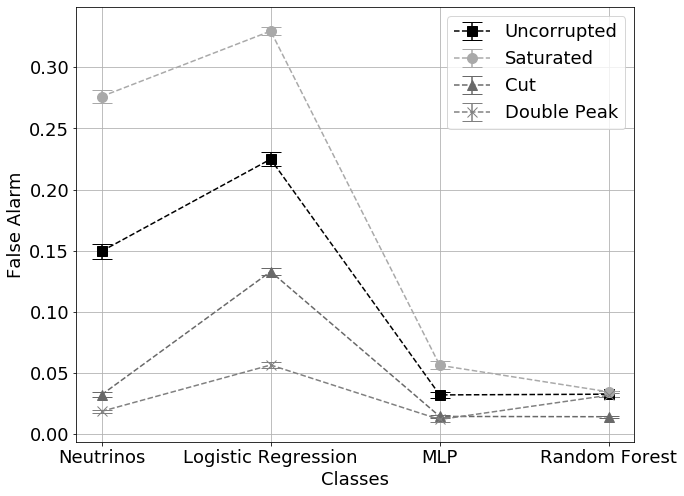

In [0]:
classes = np.array(['Good', 'Saturated', 'Cut', 'Double Peak'])

plt.figure(figsize=(10,8))
plt.errorbar(clf_lb, fa_sig_mean, yerr=fa_sig_erro,capsize=10,fmt='--s',label='Uncorrupted',markersize=10,color='black')
plt.errorbar(clf_lb, fa_sat_mean, yerr=fa_sat_erro,capsize=10,fmt='--o',label='Saturated',markersize=10,color='darkgrey')
plt.errorbar(clf_lb, fa_cut_mean, yerr=fa_cut_erro,capsize=10,fmt='--^',label='Cut',markersize=10,color='dimgray')
plt.errorbar(clf_lb, fa_dpc_mean, yerr=fa_dpc_erro,capsize=10,fmt='--x',label='Double Peak',markersize=10,color='gray')


plt.grid()
plt.legend()
plt.xlabel('Classes')
plt.ylabel('False Alarm')

plt.savefig('falseAlarm.pdf', format='pdf',dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()